In [1]:
import matplotlib.pyplot as plt
import scipy.stats as sps
from scipy.special import erfinv
import numpy as np
import math
import random
from tqdm import tqdm

Функция генерации выборки с первой практики

In [2]:
def generate_n_random_numbers(N: int, distribution: str):
    """
    N - size of sample
    distribution - ["Uniform[0, 1]", "Uniform[-1, 1]", "2xUniform[-1, 1]", "3xUniform[-1, 1]", "Cauchy(0, 1)", Norm(0, 1)]
    """
    match distribution:
        case "Uniform[0, 1]":
            return [random.uniform(0, 1) for _ in range(N)]
        case "Uniform[-1, 1]":
            return [random.uniform(0, 1) * 2 - 1 for _ in range(N)]
        case "2xUniform[-1, 1]":
            t = generate_n_random_numbers(2 * N, "Uniform[-1, 1]")
            return [t[2 * i] + t[2 * i + 1] for i in range(N)]
        case "3xUniform[-1, 1]":
            t = generate_n_random_numbers(3 * N, "Uniform[-1, 1]")
            return [t[3 * i] + t[3 * i + 1] + t[3 * i + 2] for i in range(N)]
        case "Cauchy(0, 1)":
            t = generate_n_random_numbers(N, "Uniform[0, 1]")
            return list(map(lambda x: math.tan(math.pi * (x - 0.5)), t))
        case "Norm(0, 1)":
            return [random.normalvariate(0, 1) for _ in range(N)]
        case _:
            return []

In [3]:
P = 0.95
PERCENTILE = ((1 - P) / 2) * 100
ANALYTICAL_EXPECTATION = 0
ITERATIONS = 10 ** 3
BOOTSTRAP_SIZE = 1000
NS = [10, 100, 1000]

Функция традиционного подсчёта доверительного интервала (как на второй практике) для сравнения 

In [4]:
def traditional_confidence_interval(sample: list,
                                    quantil: float,
                                    sigma_squared: float) -> tuple:
    term = quantil * math.sqrt(sigma_squared) / math.sqrt(len(sample))
    c_star = calculate_c_star(sample)
    return (c_star - term, c_star + term)


def calculate_c_star(x: list):
    return sum(x) / len(x)

Альтернативный способ подсчёта доверительного интервала для математического ожидания методом bootstrap

In [5]:
def bootstrap_confidence_interval(sample: list) -> tuple:
    bootstrap_samples = bootstrap(sample)
    bootstrap_means = [np.mean(sample) for sample in bootstrap_samples]
    return (np.percentile(bootstrap_means, PERCENTILE),
            np.percentile(bootstrap_means, 100 - PERCENTILE))


def bootstrap(data: list):
    return [np.random.choice(data, size=len(data), replace=True)
            for _ in range(BOOTSTRAP_SIZE)]

И подсчёт доверительного интервала методом JackKnife

In [6]:
z_score = np.sqrt(2) * erfinv(P)

def jackknife_confidence_interval(sample: list) -> tuple:
    sample_mean = np.mean(sample)
    jack_means = np.apply_along_axis(np.mean, 1, jackknife(sample))
    mean_jack_means = np.mean(jack_means)
    # jackknife bias
    n = len(sample)
    bias = (n - 1) * (mean_jack_means - sample_mean)
    # jackknife standard error
    terms = np.apply_along_axis(lambda x: pow(x - mean_jack_means, 2), 0, jack_means)
    std_err = np.sqrt((n - 1) * np.mean(terms))
    # bias-corrected "jackknifed estimate"
    estimate = sample_mean - bias
    return (estimate - std_err * z_score,
            estimate + std_err * z_score)


def jackknife(data: list):
    return [np.delete(data, i) for i in range(len(data))]

Сгенерируем по $10^3$ выборок разных размеров для каждого распределения и проверим, какая доля из них будет попадать в доверительный интервал, подсчитанный каждым из трёх методов

In [7]:
distros = ["Uniform[-1, 1]", "Norm(0, 1)", "2xUniform[-1, 1]"]
sigma_squared = {"Uniform[-1, 1]": 1 / 3,
                    "Norm(0, 1)": 1,
                    "2xUniform[-1, 1]": 2 / 3}
quantil = sps.norm(loc=0, scale=1).ppf((1 + P) / 2)

In [8]:
print("Start generating samples...")
samples = {d: [[generate_n_random_numbers(n, d) for _ in range(ITERATIONS)]
                for n in NS] for d in tqdm(distros)}
print("Samples generated.")

Start generating samples...


100%|██████████| 3/3 [00:01<00:00,  1.66it/s]

Samples generated.


Distribution Uniform[-1, 1], samples size = 10


100%|██████████| 1000/1000 [00:20<00:00, 48.08it/s]


Distribution Uniform[-1, 1], samples size = 100


100%|██████████| 1000/1000 [00:25<00:00, 39.66it/s]


Distribution Uniform[-1, 1], samples size = 1000


100%|██████████| 1000/1000 [01:36<00:00, 10.39it/s]


Results for distribution Uniform[-1, 1]
[0.968, 0.938, 0.947] (tranditional)
[0.927, 0.933, 0.946] (bootstrap)
[0.936, 0.932, 0.95] (jackknife)
----------------------------------------
Distribution Norm(0, 1), samples size = 10


100%|██████████| 1000/1000 [00:19<00:00, 50.04it/s]


Distribution Norm(0, 1), samples size = 100


100%|██████████| 1000/1000 [00:24<00:00, 40.51it/s]


Distribution Norm(0, 1), samples size = 1000


100%|██████████| 1000/1000 [01:36<00:00, 10.35it/s]


Results for distribution Norm(0, 1)
[0.949, 0.938, 0.961] (tranditional)
[0.9, 0.933, 0.959] (bootstrap)
[0.915, 0.937, 0.959] (jackknife)
----------------------------------------
Distribution 2xUniform[-1, 1], samples size = 10


100%|██████████| 1000/1000 [00:20<00:00, 49.15it/s]


Distribution 2xUniform[-1, 1], samples size = 100


100%|██████████| 1000/1000 [00:24<00:00, 40.00it/s]


Distribution 2xUniform[-1, 1], samples size = 1000


100%|██████████| 1000/1000 [01:36<00:00, 10.39it/s]


Results for distribution 2xUniform[-1, 1]
[0.94, 0.949, 0.948] (tranditional)
[0.896, 0.94, 0.945] (bootstrap)
[0.911, 0.947, 0.947] (jackknife)
----------------------------------------


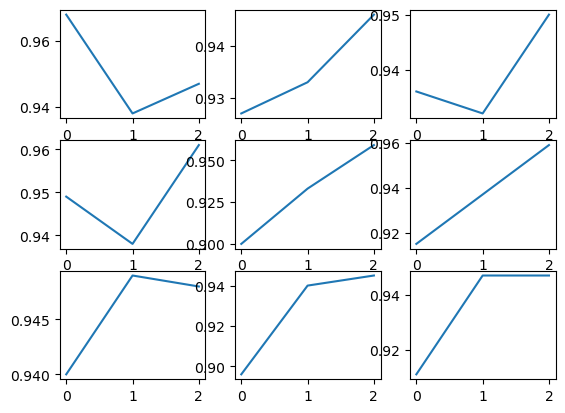

In [9]:
_, axis = plt.subplots(3, 3)
for i, d in enumerate(distros):
    results = []
    results_bs = []
    results_jk = []
    for n_id, n in enumerate(NS):
        hits_counter = 0
        hits_counter_bs = 0
        hits_counter_jk = 0
        print(f"Distribution {d}, samples size = {n}")
        for sample in tqdm(samples[d][n_id]):
            d_left, d_right = traditional_confidence_interval(sample, quantil, sigma_squared[d])
            hits_counter += d_left <= ANALYTICAL_EXPECTATION <= d_right

            d_left_bs, d_right_bs = bootstrap_confidence_interval(sample)
            hits_counter_bs += d_left_bs <= ANALYTICAL_EXPECTATION <= d_right_bs

            d_left_jk, d_right_jk = jackknife_confidence_interval(sample)
            hits_counter_jk += d_left_jk <= ANALYTICAL_EXPECTATION <= d_right_jk

        results.append(hits_counter / ITERATIONS)
        results_bs.append(hits_counter_bs / ITERATIONS)
        results_jk.append(hits_counter_jk / ITERATIONS)

    print(f"Results for distribution {d}\n"
            f"{results} (tranditional)\n"
            f"{results_bs} (bootstrap)\n"
            f"{results_jk} (jackknife)\n", '-' * 40, sep='')
    axis[i][0].plot(range(len(results)), results)
    axis[i][1].plot(range(len(results_bs)), results_bs)
    axis[i][2].plot(range(len(results_jk)), results_jk)
plt.show()

На графике изображена доля испытаний, в которых доверительный интервал накрывает реальное матожидание 0. По строкам идут распределения (сверху вниз: $\text{Uniform}[-1, 1]$, $\text{Norm}(0, 1)$ и $2\cdot \text{Uniform}[-1, 1]$), по столбцам идут методы (слева направо: классический, бутстрэп и джекнайф). На каждом графике отображена доля по оси ординат, и $\log_{10}(sample\_length)$ по оси абсцисс. Для каждой точки проведено $10^3$ испытаний.